In [19]:
#!pip install langchain

In [20]:
#pip install openai

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("OPEN_API_KEY")

In [4]:
from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate, FewShotPromptTemplate, OpenAI
import json

In [5]:
reasoning_prompt="{question}\nLet's think step by step!"
Zeroshotprompt=PromptTemplate(
    template=reasoning_prompt,
    input_variables=['question']
)
model=ChatOpenAI(openai_api_key=secret_value_0,model_name="gpt-3.5-turbo",temperature=0)
Zeroshotchain=Zeroshotprompt|model

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [7]:
questions = []
answers = []
decoder = json.JSONDecoder()
with open('/kaggle/input/school-math/test.jsonl') as f:
    lines = f.readlines()
    for line in lines:
        json_res = json.loads(line)
        questions.append(json_res["question"].strip())
        answers.append(json_res["answer"])#.split("#### ")[-1]
        

In [8]:
questions[2]

'Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?'

In [9]:
answers[2].split('\n')

['The cost of the house and repairs came out to 80,000+50,000=$<<80000+50000=130000>>130,000',
 'He increased the value of the house by 80,000*1.5=<<80000*1.5=120000>>120,000',
 'So the new value of the house is 120,000+80,000=$<<120000+80000=200000>>200,000',
 'So he made a profit of 200,000-130,000=$<<200000-130000=70000>>70,000',
 '#### 70000']

In [10]:
for s in Zeroshotchain.stream({"question": questions[2]}):
    print(s.content, end="", flush=True)

Step 1: Calculate the increase in value of the house after repairs.
Original value of the house = $80,000
Increase in value after repairs = 150% of $80,000 = 1.5 * $80,000 = $120,000

Step 2: Calculate the total cost of buying and repairing the house.
Total cost = Cost of buying the house + Cost of repairs
Total cost = $80,000 + $50,000 = $130,000

Step 3: Calculate the profit made from flipping the house.
Profit = Increase in value - Total cost
Profit = $120,000 - $130,000
Profit = $10,000

Josh made a profit of $10,000 from flipping the house.

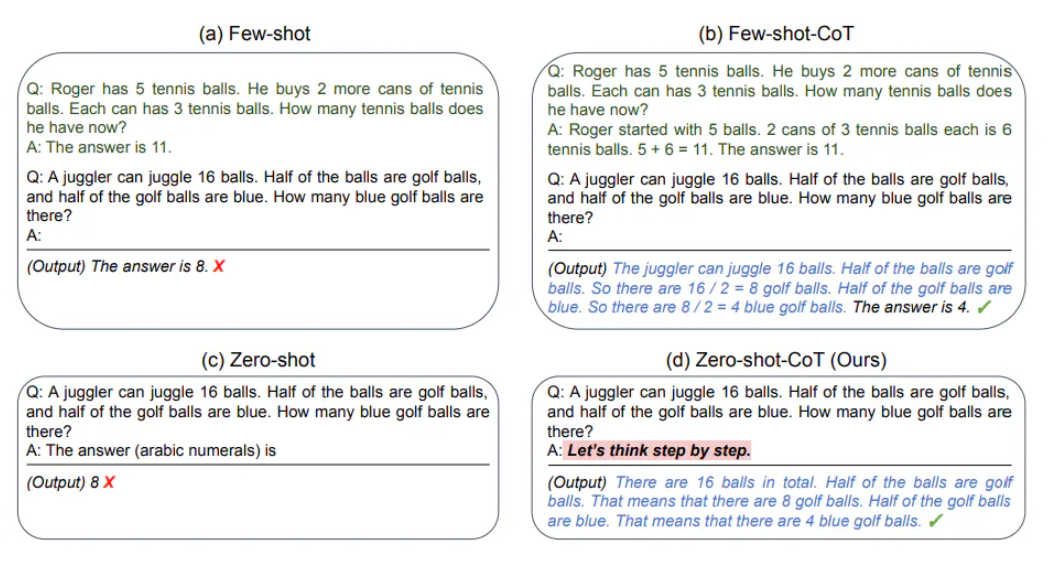

# AS we can see the model generated worng answer

In [11]:
EXAMPLES=[
    {"question":questions[0],
    "answer":answers[0].split('\n'),
    },
    {"question":questions[1],
    "answer":answers[1].split('\n'),
    },
    {"question":questions[5],
    "answer":answers[5].split('\n'),
    },
    {"question":questions[3],
    "answer":answers[3].split('\n'),
    },
    {"question":questions[4],
    "answer":answers[4].split('\n'),
    },
]

In [12]:
# Template to be used
example_template ="""
User: "{question}\nLet's think step by step!"
AI: {answer}
"""



In [13]:
example_prompt = PromptTemplate(
    input_variables = ["question","answer"],
    template = example_template
)

In [14]:
suffix = """
User: {question}
AI:
"""

In [15]:
Fewshotprompt = FewShotPromptTemplate(
    examples=EXAMPLES,
    example_prompt=example_prompt,
    suffix=suffix,
    input_variables=["question"],
)

In [16]:
Fewshotchain=Fewshotprompt|model

In [17]:
for s in Fewshotchain.stream({"question": questions[2]}):
    print(s.content, end="", flush=True)

['The increase in value due to repairs is 150% of $80,000, which is 150/100 * $80,000 = $<<150/100*80000=120000>>120,000.',
 'So the total value of the house after repairs is $80,000 + $120,000 = $<<80000+120000=200000>>200,000.',
 'Josh's total investment was $80,000 + $50,000 = $<<80000+50000=130000>>130,000.',
 'Therefore, Josh made a profit of $200,000 - $130,000 = $<<200000-130000=70000>>70,000.',
 '#### 70,000']

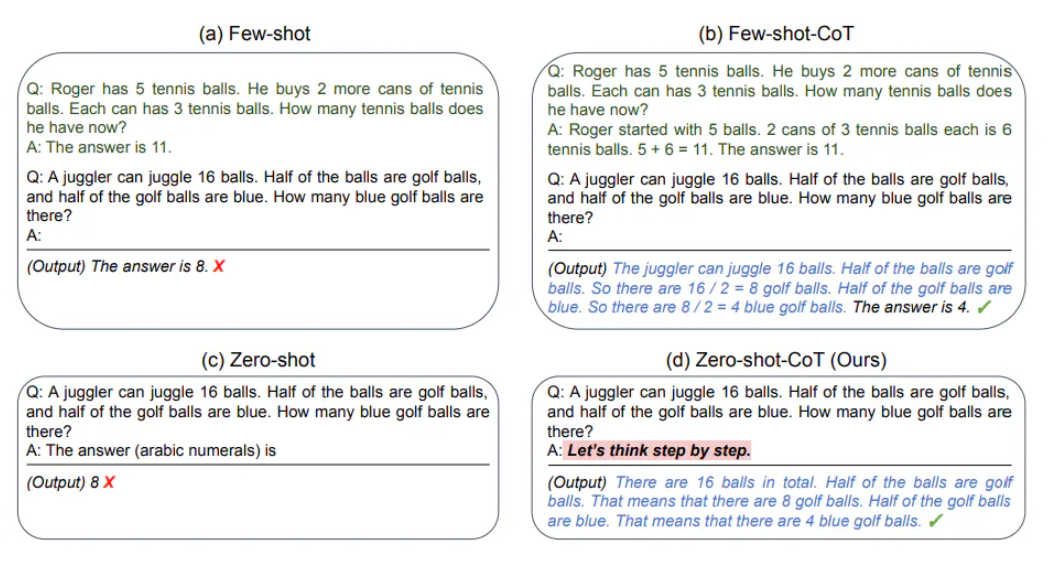

In [18]:
for s in Fewshotchain.stream({"question": "A juggler can juggle 16 balls. Half of the balls are golf balls, and half of the golf balls are blue. How many blue golf balls are there?"}):
    print(s.content, end="", flush=True)

['There are 16/2 = <<16/2=8>>8 golf balls.', 'So there are 8/2 = <<8/2=4>>4 blue golf balls.', '#### 4']